/opt/conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 1, 3])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 1/1000, Total Reward: 1814040.2910007057
Episode 2/1000, Total Reward: 2828635.6711019357
Episode 3/1000, Total Reward: 2237993.194137216
Episode 4/1000, Total Reward: 927460.4747027116
Episode 5/1000, Total Reward: 2236980.744241442
Episode 6/1000, Total Reward: 2132136.9102468705
Episode 7/1000, Total Reward: 1638472.057064731
Episode 8/1000, Total Reward: 2771604.8624591576
Episode 9/1000, Total Reward: 2070148.693197
Episode 10/1000, Total Reward: 1950258.147385794
Episode 11/1000, Total Reward: 2226108.3813996427
Episode 12/1000, Total Reward: 1273336.3208505977
Episode 13/1000, Total Reward: 2304771.5710757663
Episode 14/1000, Total Reward: 1505224.1167481393
Episode 15/1000, Total Reward: 2830451.549526031
Episode 16/1000, Total Reward: 2012571.0076473402
Episode 17/1000, Total Reward: 2020814.6645360317
Episode 18/1000, Total Reward: 1544495.494323638
Episode 19/1000, Total Reward: 1860655.6614194002
Episode 20/1000, Total Reward: 3010144.8274019533
Episode 21/1000, Tot

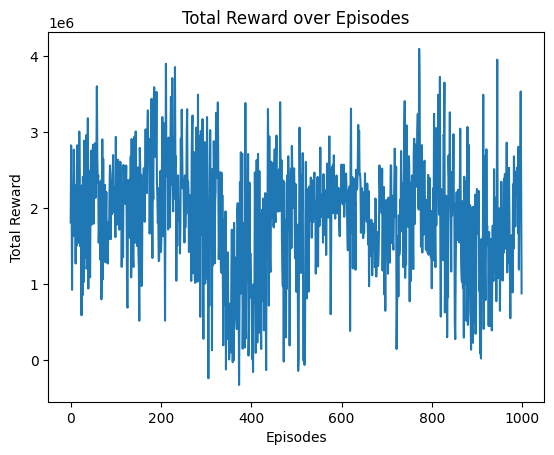

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# 비트코인 가격 데이터 로딩
def load_data():
    df = pd.read_csv('/workspace/BTCUSDT/BTCUSDT-1d-2023.csv')
    return df

# 비트코인 매매 환경 (gym 없이 구현)
class BitcoinTradingEnv:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.balance = 10000  # 초기 자본
        self.bitcoin_held = 0
        self.max_steps = len(data) - 1
        self.state_size = 5  # Open, High, Low, Close, Volume
        self.action_space = 3  # 3개의 액션: 0-매도, 1-매수, 2-기다림

    def reset(self):
        self.current_step = 0
        self.balance = 10000
        self.bitcoin_held = 0
        return self._next_observation()

    def _next_observation(self):
        frame = self.data.iloc[self.current_step]
        return np.array([frame['Open'], frame['High'], frame['Low'], frame['Close'], frame['Volume']])

    def step(self, action):
        current_price = self.data.iloc[self.current_step]['Close']
        
        if action == 1:  # 매수
            self.bitcoin_held += self.balance / current_price
            self.balance = 0
        elif action == 0:  # 매도
            self.balance += self.bitcoin_held * current_price
            self.bitcoin_held = 0
        
        self.current_step += 1
        done = self.current_step >= self.max_steps
        reward = self.balance + self.bitcoin_held * current_price - 10000  # 초기 자본에서의 차이로 수익률 계산
        return self._next_observation(), reward, done

# DQN 네트워크 모델 정의
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQN 에이전트 정의
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99  # 할인율
        self.epsilon = 1.0  # 탐험율
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        q_values = self.model(states)
        q_values_next = self.target_model(next_states)

        target = q_values.clone()
        for i in range(self.batch_size):
            if dones[i]:
                target[i, actions[i]] = rewards[i]
            else:
                target[i, actions[i]] = rewards[i] + self.gamma * torch.max(q_values_next[i])

        loss = nn.MSELoss()(q_values.gather(1, actions.unsqueeze(1)), target.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

# 학습 및 테스트
def train_dqn(env, agent, episodes=1000):
    rewards = []
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.replay()
            agent.update_target_model()
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
        print(f"Episode {e+1}/{episodes}, Total Reward: {total_reward}")
    return rewards

# 데이터 로드 및 환경 설정
df = load_data()
env = BitcoinTradingEnv(df)
agent = DQNAgent(state_size=5, action_size=3)

# DQN 학습
rewards = train_dqn(env, agent, episodes=1000)

# 학습된 결과 시각화
plt.plot(rewards)
plt.title('Total Reward over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()


In [4]:
def evaluate_dqn(env, agent, test_episodes=100):
    total_rewards = []
    for e in range(test_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)  # 모델이 선택한 액션
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state
        total_rewards.append(total_reward)  # 에피소드 별 총 보상
        print(f"Test Episode {e+1}/{test_episodes}, Total Reward: {total_reward}")
    
    # 평가 결과 시각화
    plt.plot(total_rewards)
    plt.title('Total Reward over Test Episodes')
    plt.xlabel('Test Episodes')
    plt.ylabel('Total Reward')
    plt.show()

    return total_rewards


Test Episode 1/100, Total Reward: -1368298.4993634801
Test Episode 2/100, Total Reward: -1506437.0177006803
Test Episode 3/100, Total Reward: -1474592.0595512837
Test Episode 4/100, Total Reward: -1435788.2626100262
Test Episode 5/100, Total Reward: -1474592.0595512837
Test Episode 6/100, Total Reward: -1474592.0595512837
Test Episode 7/100, Total Reward: -1438408.8982598376
Test Episode 8/100, Total Reward: -1523821.3896613938
Test Episode 9/100, Total Reward: -1452360.9394627695
Test Episode 10/100, Total Reward: -1406447.4716662683
Test Episode 11/100, Total Reward: -1517168.9321060523
Test Episode 12/100, Total Reward: -1474592.0595512837
Test Episode 13/100, Total Reward: -1474592.0595512837
Test Episode 14/100, Total Reward: -1483818.015036613
Test Episode 15/100, Total Reward: -1481387.7576888278
Test Episode 16/100, Total Reward: -1524396.6266215527
Test Episode 17/100, Total Reward: -1455905.7196661488
Test Episode 18/100, Total Reward: -1474592.0595512837
Test Episode 19/100,

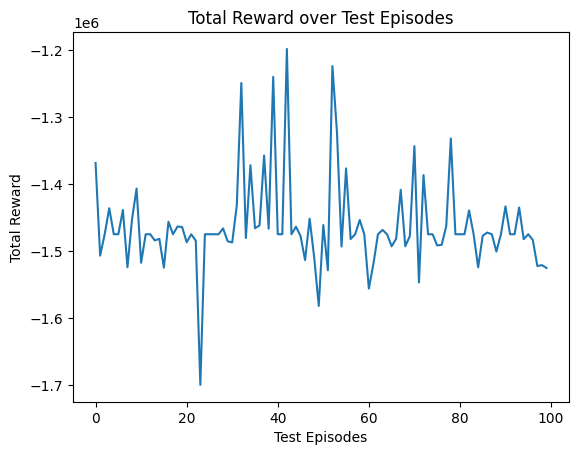

In [5]:
# 테스트 데이터로 모델 평가
df_test = pd.read_csv('/workspace/BTCUSDT/BTCUSDT-1d-2022.csv')  # 테스트 데이터 로드 (학습 데이터와 별개로 사용)
env_test = BitcoinTradingEnv(df_test)
test_rewards = evaluate_dqn(env_test, agent, test_episodes=100)
